In [6]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
# Creating and splitting dataframe

train_dir = './data/raw/train'

image_paths = []
labels = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            image_paths.append(f'{class_name}/{filename}')
            labels.append(class_name)

df = pd.DataFrame({'filename': image_paths, 'label':labels})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.head()

,filename,label
23311,cat/cat.11209.jpg,cat
23623,cat/cat.2658.jpg,cat
1020,dog/dog.12201.jpg,dog
12645,cat/cat.8552.jpg,cat
1533,dog/dog.10743.jpg,dog


In [8]:
image_size = (200, 200)

datagen = ImageDataGenerator(rescale=1.0/255)

train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=16,
    class_mode='categorical'
    )

test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=16,
    class_mode='categorical'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [9]:
model = Sequential()

model.add(Conv2D(input_shape=(200,200,3), filters=16, kernel_size=(3,3), padding='valid', activation=None))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = "valid", activation = None))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size =(2,2),strides =(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-07 14:19:58.505976: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78675968 exceeds 10% of free system memory.
2025-02-07 14:19:58.606248: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78675968 exceeds 10% of free system memory.


In [10]:
checkpoint = ModelCheckpoint('opt_model.keras', monitor = "val_accuracy", verbose = 1, save_best_only = True, save_weights_only = False, mode = "auto")
early = EarlyStopping(monitor = "val_accuracy", patience = 3, verbose = 1, mode = "auto")
model.fit(train_data, steps_per_epoch = 125, validation_data = test_data, validation_steps = 10, epochs = 10, callbacks = [checkpoint, early])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.5429 - loss: 0.9604
Epoch 1: val_accuracy improved from -inf to 0.48750, saving model to opt_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 775ms/step - accuracy: 0.5430 - loss: 0.9593 - val_accuracy: 0.4875 - val_loss: 0.8065
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5913 - loss: 0.6714
Epoch 2: val_accuracy improved from 0.48750 to 0.50625, saving model to opt_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 720ms/step - accuracy: 0.5914 - loss: 0.6714 - val_accuracy: 0.5063 - val_loss: 0.6888
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.6519 - loss: 0.6418
Epoch 3: val_accuracy improved from 0.50625 to 0.60625, saving model to opt_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6519 - loss: 0.6418 - val_accuracy: 0.6062 - val_loss: 0.6604
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.6473 - loss: 0.6363
Epoch 4: val_accuracy improv

In [11]:
train_data.class_indices

{'cat': 0, 'dog': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


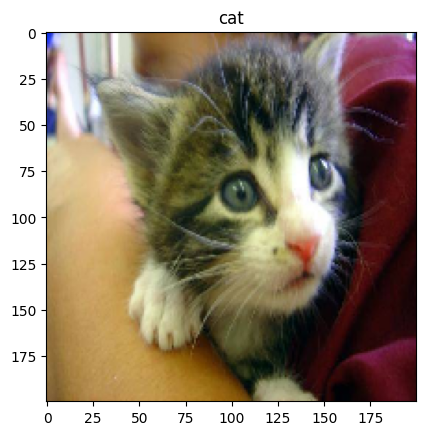

In [12]:
# Predict a random image

rand_num = np.random.randint(1,12500)
path_to_rand = './data/raw/test/' + str(rand_num) + '.jpg'

img = image.load_img(path_to_rand, target_size=(200,200))

img = np.asarray(img)

plt.imshow(img)

img = np.expand_dims(img, axis=0)

output = model.predict(img)

if output[0][0] > output[0][1]:
    plt.title('cat')
else:
    plt.title('dog')
